In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
C:\Users\hhhwa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hhhwa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hhhwa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hhhwa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
df  = pd.read_csv('C:/Users/hhhwa/Desktop/process_data/Historical Product Demand.csv', parse_dates=['Date'])

Product_Code(2160) / Warehouse(4) / Product_Category(34) / Date / Order_Demand

In [3]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50


Data Preprocessing

In [4]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

1  /  5
11239  /  1048575


In [5]:
#Lets check where these nulls are.
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)
#There are missing values in Dates.

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [6]:
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[0:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
17249,Product_0608,Whse_C,Category_001,2011-09-27,5
17250,Product_1933,Whse_C,Category_001,2011-09-27,23
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450
131426,Product_0125,Whse_S,Category_011,2011-10-20,-2
131429,Product_0412,Whse_S,Category_007,2011-10-20,-2


In [7]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [8]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

In [9]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2
196928,Product_0614,Whse_S,Category_001,2012-01-02,3
200087,Product_1281,Whse_S,Category_019,2012-01-02,14000
200086,Product_1355,Whse_S,Category_019,2012-01-02,5000
77313,Product_2169,Whse_S,Category_024,2012-01-02,55
...,...,...,...,...,...
995585,Product_0200,Whse_A,Category_007,2016-12-30,20
981262,Product_1388,Whse_A,Category_019,2016-12-30,100
999913,Product_1341,Whse_S,Category_019,2016-12-30,15000
981263,Product_1513,Whse_A,Category_019,2016-12-30,100


Exploring the Data as TIME SERIES

Considering only Order_Demand

In [10]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df = df.set_index('Date')
df.index
y = df['Order_Demand'].resample('MS').mean()

In [11]:
y.head()

Date
2012-01-01    2.555132e+06
2012-02-01    3.088279e+06
2012-03-01    3.054448e+06
2012-04-01    2.653303e+06
2012-05-01    2.963562e+06
Freq: MS, Name: Order_Demand, dtype: float64

Reset df

In [12]:
df  = pd.read_csv('C:/Users/hhhwa/Desktop/process_data/Historical Product Demand.csv', parse_dates=['Date'])
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

Classified by category

In [13]:
df1 = pd.DataFrame(df.groupby('Product_Category')['Order_Demand'].sum().sort_values(ascending=False))
df1["% Contribution"] = df1['Order_Demand']/df1['Order_Demand'].sum()*100
df1

,Order_Demand,% Contribution
Product_Category,,
Category_019,4213068570,82.673263
Category_006,401219159,7.873144
Category_005,197679740,3.879080
Category_007,127696217,2.505789
Category_028,47169520,0.925610
Category_033,42370000,0.831429
Category_030,40024855,0.785410
Category_032,4424920,0.086830
Category_021,4340660,0.085177


In [14]:
df2 = pd.pivot_table(df,index=["Date"],values=["Order_Demand"],columns=["Product_Category"],aggfunc=np.sum)
df2.columns = df2.columns.droplevel(0)
df2["Category_019"].dropna()

Date
2012-01-02     653950.0
2012-01-03    1499806.0
2012-01-04     626100.0
2012-01-05    7458199.0
2012-01-06    3442875.0
                ...    
2016-12-26    3001006.0
2016-12-27    1334994.0
2016-12-28    1830121.0
2016-12-29     388451.0
2016-12-30     621700.0
Name: Category_019, Length: 1579, dtype: float64

In [15]:
y_1 = df2.resample('MS').sum() # Resampling the data on monthly basis 
y_1.index.freq = "MS" # Setting datetime frequency to Month
y_1.head(10)

Product_Category,Category_001,Category_002,Category_003,Category_004,Category_005,Category_006,Category_007,Category_008,Category_009,Category_010,...,Category_024,Category_025,Category_026,Category_027,Category_028,Category_029,Category_030,Category_031,Category_032,Category_033
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,22055.0,0.0,5848.0,900.0,2868545.0,6321967.0,2058259.0,268.0,46502.0,105.0,...,11777.0,0.0,3179.0,0.0,507940.0,32.0,406350.0,372.0,30010.0,600000.0
2012-02-01,25398.0,0.0,5750.0,3260.0,3203650.0,6431061.0,2423222.0,240.0,65443.0,97.0,...,17913.0,9000.0,6304.0,0.0,462939.0,628.0,657850.0,210.0,114560.0,900000.0
2012-03-01,29396.0,0.0,7657.0,2880.0,3227430.0,6205094.0,2485655.0,92.0,55390.0,88.0,...,23248.0,3000.0,5929.0,0.0,558869.0,753.0,553450.0,331.0,20982.0,530000.0
2012-04-01,20489.0,0.0,7244.0,1220.0,2596790.0,5845692.0,2781866.0,517.0,70758.0,161.0,...,21734.0,0.0,6868.0,0.0,373579.0,494.0,457450.0,118.0,60868.0,830000.0
2012-05-01,20360.0,0.0,8972.0,270.0,3433700.0,6416599.0,1706125.0,580.0,61703.0,1903.0,...,14670.0,0.0,7885.0,0.0,766972.0,725.0,431151.0,218.0,34736.0,880000.0
2012-06-01,21199.0,0.0,8384.0,4500.0,3236360.0,5604352.0,1891858.0,77.0,82177.0,75.0,...,21412.0,0.0,4272.0,0.0,1150902.0,1160.0,525050.0,253.0,120512.0,880000.0
2012-07-01,20034.0,0.0,5739.0,2140.0,2947725.0,4743436.0,1456262.0,208.0,59449.0,814.0,...,19942.0,0.0,5621.0,0.0,801559.0,292.0,470350.0,355.0,21576.0,710000.0
2012-08-01,17981.0,0.0,2779.0,3220.0,2735340.0,6000516.0,2338021.0,630.0,40163.0,444.0,...,13346.0,3000.0,4450.0,0.0,641566.0,822.0,830050.0,199.0,64918.0,700000.0
2012-09-01,19782.0,0.0,6962.0,1973.0,2586780.0,4132710.0,1377977.0,239.0,71319.0,151.0,...,12446.0,0.0,3818.0,0.0,787579.0,694.0,423350.0,488.0,18936.0,700000.0


In [16]:
df_019 = pd.DataFrame(y_1["Category_019"])
df_019.head()

,Category_019
Date,
2012-01-01,61068659.0
2012-02-01,71882600.0
2012-03-01,71581780.0
2012-04-01,61010298.0
2012-05-01,71930220.0


In [17]:
y_019 = df_019['Category_019'].resample('M').mean()

Classified by Warehouse

In [18]:
df4 = pd.DataFrame(df.groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False))
df4["% Contribution"] = df4['Order_Demand']/df4['Order_Demand'].sum()*100
df4

,Order_Demand,% Contribution
Warehouse,,
Whse_J,3344066262,65.620786
Whse_S,1030165015,20.214982
Whse_C,578777987,11.357390
Whse_A,143038014,2.806842


In [19]:
df5 = pd.pivot_table(df,index=["Date"],values=["Order_Demand"],columns=["Warehouse"],aggfunc=np.sum)
df5.columns = df5.columns.droplevel(0)
df5["Whse_J"].dropna()

Date
2012-01-04        120.0
2012-01-05    4701940.0
2012-01-06    3822135.0
2012-01-09        200.0
2012-01-10    4315961.0
                ...    
2016-12-25          0.0
2016-12-26    2972644.0
2016-12-27    1188951.0
2016-12-28    2068050.0
2016-12-29     139046.0
Name: Whse_J, Length: 1394, dtype: float64

In [20]:
y_2 = df5.resample('MS').sum() # Resampling the data on monthly basis 
y_2.index.freq = "MS" # Setting datetime frequency to Month
y_2.head(10)

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Date,,,,
2012-01-01,1919617.0,4234664.0,51323929.0,16620625.0
2012-02-01,2534811.0,10966946.0,56651205.0,16318862.0
2012-03-01,2323694.0,11296947.0,54044436.0,17859473.0
2012-04-01,1912717.0,7022400.0,49577646.0,15779726.0
2012-05-01,2638848.0,8203107.0,51135141.0,23966191.0
2012-06-01,2471301.0,8680937.0,53006078.0,19018297.0
2012-07-01,2437207.0,10815331.0,51664335.0,21839496.0
2012-08-01,2629323.0,9510199.0,47156208.0,15437809.0
2012-09-01,2221520.0,4733871.0,42940715.0,11573051.0


In [21]:
df_J = pd.DataFrame(y_2["Whse_J"])
df_J.head()

,Whse_J
Date,
2012-01-01,51323929.0
2012-02-01,56651205.0
2012-03-01,54044436.0
2012-04-01,49577646.0
2012-05-01,51135141.0


In [22]:
y_J = df_J['Whse_J'].resample('M').mean()

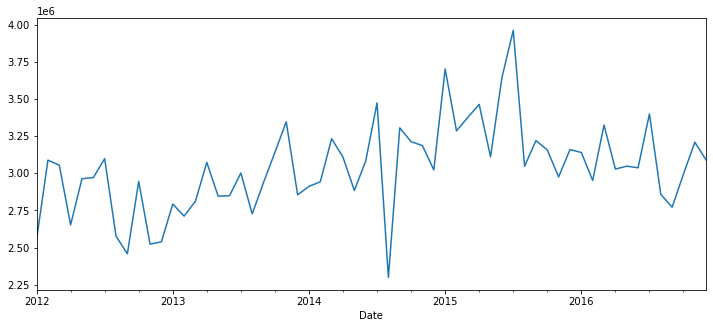

In [23]:
y.plot(figsize=(12,5))
#y_019.plot(figsize=(12,5))
#y_J.plot(figsize=(12,5))
plt.show()

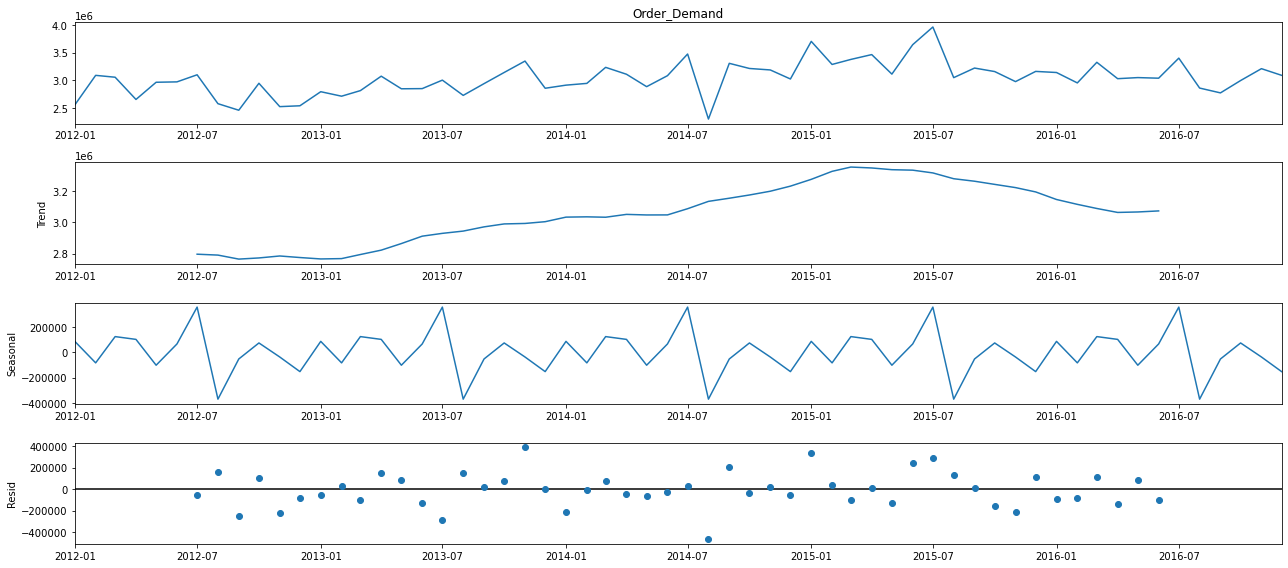

In [24]:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#decomposition = sm.tsa.seasonal_decompose(y_019, model='additive')
#decomposition = sm.tsa.seasonal_decompose(y_J, model='additive')
fig = decomposition.plot()
plt.show()

**ARIMA**

Theory on ARIMA

An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):

 - p is the order of the AR term (number of lags of Y to be used as predictors). If it snowed for the last wee, it is likely it will snow tomorrow.
 - q is the order of the MA term (moving average).
 - d is the number of differencing required to make the time series stationary. if already stationary d=0.
 
But when dealing with SEASONALITY, it is best to incorporate it as 's'. ARIMA(p,d,q)(P,D,Q)s. Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.



In [25]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            #y_019,
                                            #y_J,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1931.5634282849132
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.4361148419841
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1339.6881722069236
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3174.1498643792493
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1367.342362003335
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1341.6788736718381
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.8874178559138
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3058.430343555963
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1861.466719033701
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1470.6819924566387
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1306.1619297383031
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3087.4706165102652
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1528.580793665934
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.1406721760206
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1021.2043416532866
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3003.2173105720794
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1649.072500057203
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

C:\Users\hhhwa\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1334.2098982718953
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1335.4277790813292
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:990.3503626070177
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3087.2872838128164
SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1620.888931088402
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1286.8410694830986
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1301.995461846814
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3079.6804368355
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1340.195423016816
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1287.6166884880702
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:987.6749622026335
SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2995.4271308973143
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1635.793447266306
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1296.6206320673564
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1308.560757293221
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:3129.760497100287
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1293.9024186762404
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:129

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                #y_019,
                                #y_J,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2900      0.373     -0.778      0.437      -1.021       0.441
ma.L1         -0.4086      0.329     -1.242      0.214      -1.054       0.236
ar.S.L12      -0.4405      0.205     -2.148      0.032      -0.843      -0.039
sigma2      1.019e+11   8.33e-13   1.22e+23      0.000    1.02e+11    1.02e+11


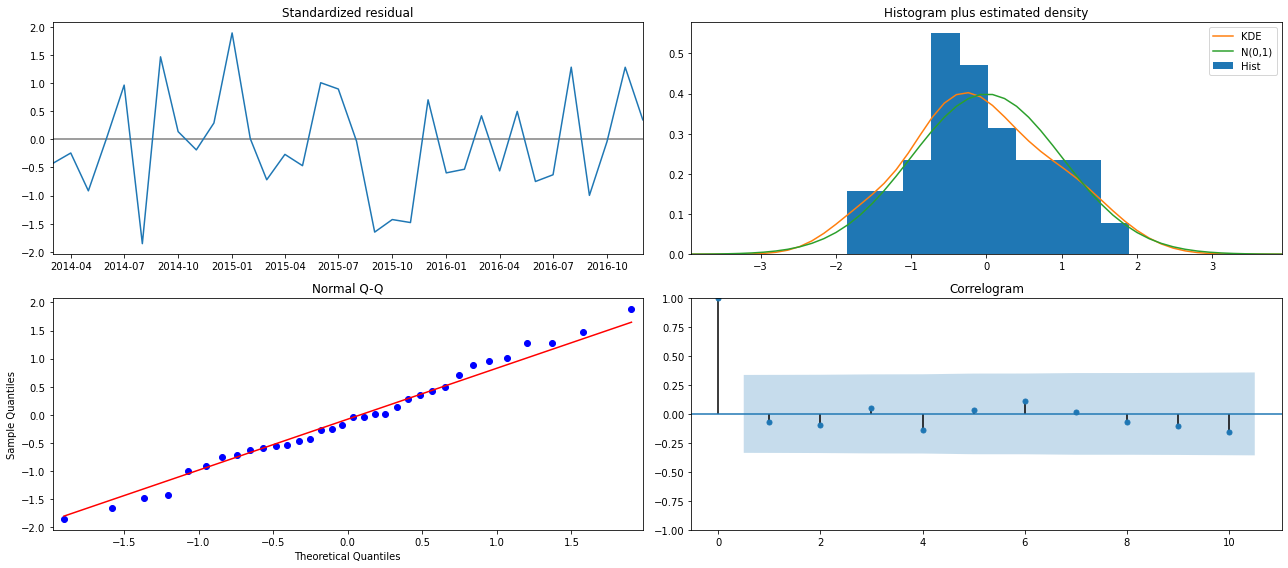

In [28]:
results.plot_diagnostics()
plt.tight_layout()
plt.show()

Model Validation

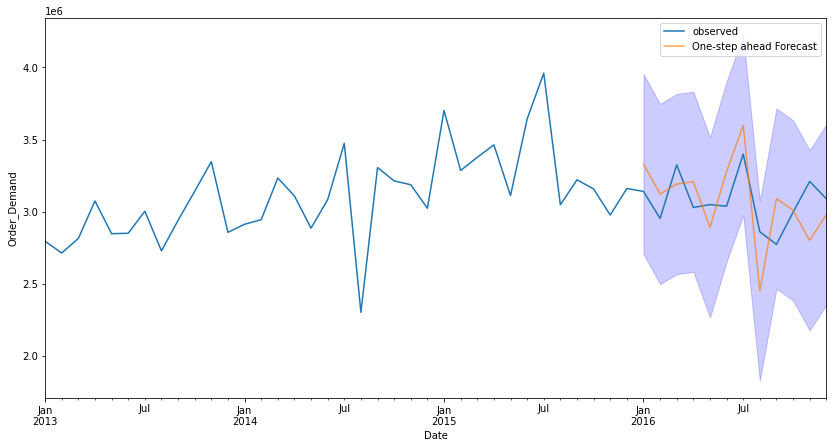

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False) #false is when using the entire history.
#pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)  ## when 

#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
# ax = y_019['2013':].plot(label='observed')
# ax = y_J['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

Forecast Accuracy

In [30]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-31':]
# y_truth = y_019['2016-01-31':]
# y_truth = y_J['2016-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 59069099388.08
RMSE: 243041.35


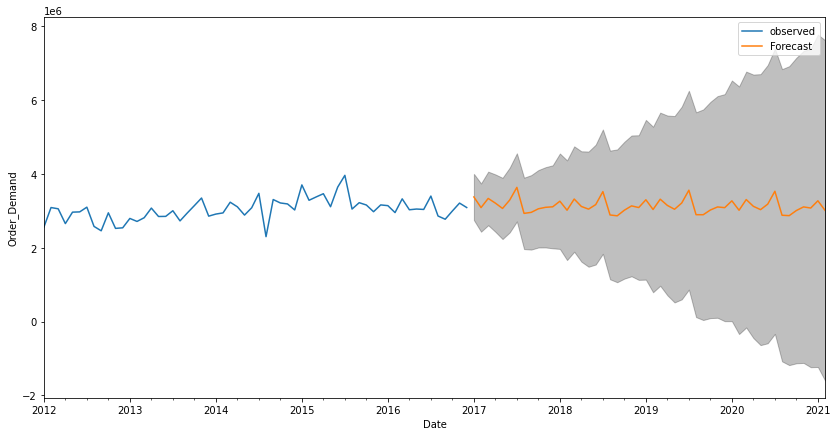

In [31]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
# ax = y_019.plot(label='observed', figsize=(14, 7))
# ax = y_J.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

**LSTM**

In [32]:
from keras.layers import Dense,Dropout,SimpleRNN,LSTM

Considering only Order_Demand

In [33]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df = df.set_index('Date')
df.index
y = df['Order_Demand'].resample('MS').mean()

In [34]:
df

,Order_Demand
Date,
2012-01-01,2
2012-01-02,680277
2012-01-03,1645257
2012-01-04,1295861
2012-01-05,8941774
...,...
2016-12-26,3527970
2016-12-27,1647426
2016-12-28,2740040


Classified by Categoty

In [35]:
#df2 = pd.pivot_table(df,index=["Date"],values=["Order_Demand"],columns=["Product_Category"],aggfunc=np.sum)
#df2.columns = df2.columns.droplevel(0)
#df2["Category_019"].dropna()

KeyError: 'Product_Category'

In [ ]:
#df_19 = df2["Category_019"].dropna()

In [ ]:
#df_19 = pd.DataFrame(df_19)

Classified by Warehouse

In [ ]:
#df_ = pd.pivot_table(df,index=["Date"],values=["Order_Demand"],columns=["Warehouse"],aggfunc=np.sum)
#df_.columns = df_.columns.droplevel(0)
#df_["Whse_J"].dropna()

In [ ]:
#df_J = df_["Whse_J"].dropna()

In [ ]:
#df_J = pd.DataFrame(df_J)

Transform the data into a time series problem

In [36]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [37]:
from sklearn.preprocessing import MinMaxScaler

look_back = 30

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(df)
#signal_data = scaler.fit_transform(df_19)
#signal_data = scaler.fit_transform(df_J)

# Data split
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# Dataset
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [38]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [39]:
ts = 30
#ts = 50 ## when y_019

In [40]:
model = Sequential()
model.add(LSTM(64, input_shape=(ts, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))


Train on 770 samples, validate on 370 samples
Epoch 1/200
770/770 [==============================] - 1s 771us/step - loss: 0.0546 - val_loss: 0.0520
Epoch 2/200
770/770 [==============================] - 0s 378us/step - loss: 0.0431 - val_loss: 0.0486
Epoch 3/200
770/770 [==============================] - 0s 378us/step - loss: 0.0427 - val_loss: 0.0497
Epoch 4/200
770/770 [==============================] - 0s 382us/step - loss: 0.0413 - val_loss: 0.0484
Epoch 5/200
770/770 [==============================] - 0s 383us/step - loss: 0.0407 - val_loss: 0.0485
Epoch 6/200
770/770 [==============================] - 0s 378us/step - loss: 0.0408 - val_loss: 0.0497
Epoch 7/200
770/770 [==============================] - 0s 382us/step - loss: 0.0403 - val_loss: 0.0489
Epoch 8/200
770/770 [==============================] - 0s 387us/step - loss: 0.0402 - val_loss: 0.0487
Epoch 9/200
770/770 [==============================] - 0s 378us/step - loss: 0.0391 - val_loss: 0.0511
Epoch 10/200
770/770 [====

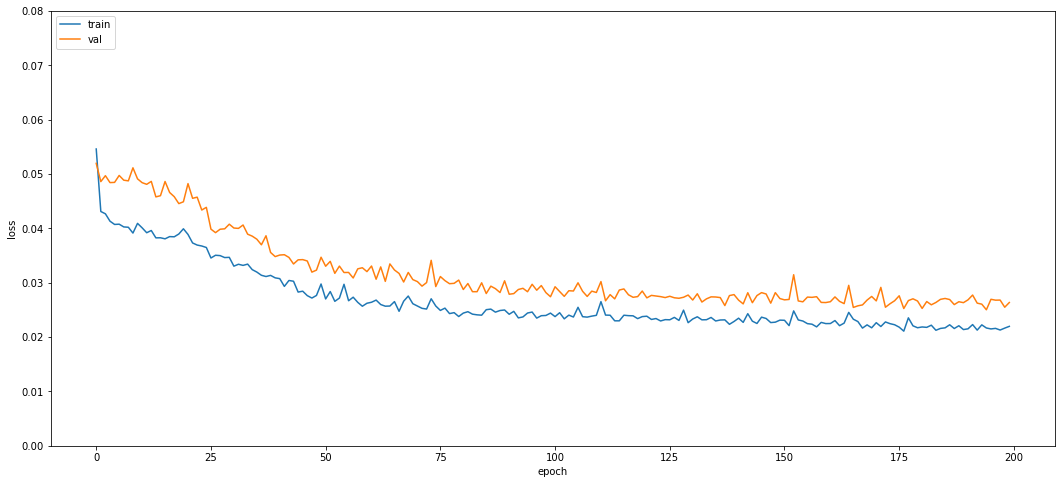

In [41]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.08)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Performance Evaluation

In [42]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.02053066540461082
Validataion Score:  0.02635792052826366
Test Score:  0.033673929368577354


In [43]:
train_pred = model.predict(x_train)
val_pred = model.predict(x_val)
test_pred = model.predict(x_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred)))
print('Val rmse:', np.sqrt(mean_squared_error(y_val, val_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, test_pred)))

Train rmse: 0.1432852575555715
Val rmse: 0.1623512257464414
Test rmse: 0.1835045782947878


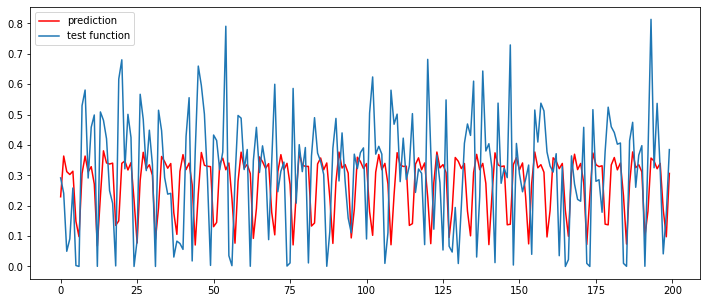

In [44]:
look_ahead = 200
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()